# Советник для противодействия легализации доходов, полученных преступным путем с использованием криптовалюты

В этом ноутбуке представлено наше решение задачи об обнаружении нелегальных криптовалютных транзакций

# Необходимые библиотеки

In [1]:
!pip install torch-geometric

import torch_geometric
from torch_geometric.data import Data, DataLoader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 682.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import torch.nn.functional as F

import networkx as nx
import seaborn as sns

import os

# Датасет 

Elliptic - компания по анализу криптовалют, специализирующаяся на надежной защите криптовалютных экосистем от преступной деятельности. В качестве вклада в исследовательское сообщество и сообщество по борьбе с отмыванием денег Elliptic согласилась публично поделиться этим набором данных на платформе Kaggle. Насколько нам известно, это самый большой в мире набор данных о транзакциях с маркировкой, общедоступный в любой криптовалюте

In [3]:
df_classes = pd.read_csv('/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_classes.csv')
df_edges = pd.read_csv('/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')
df_features = pd.read_csv('/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None)

### Описание
Elliptic DataSet сопоставляет биткойн-транзакции с реальными объектами, принадлежащими к законным категориям (биржи, поставщики кошельков, майнеры, законные сервисы и т.д.), и незаконным (мошенничество, вредоносное ПО, террористические организации, программы-вымогатели, схемы Понци и т.д.). Задача датасета состоит в том, чтобы классифицировать незаконные и законные узлы на графе.

### Содержание
Этот анонимизированный набор данных представляет собой граф транзакций, собранный из блокчейна Биткоина. Узел на графике представляет транзакцию, ребро можно рассматривать как поток биткоинов между одной транзакцией и другой. Каждый узел имеет 166 параметров и помечен как "законный", "незаконный" или "неизвестный".

### Узлы и ребра
Граф состоит из 203 769 узлов (df_classes) и 234 355 ребер (df_edges). Два процента (4545) узлов помечены как class1 (незаконные). Двадцать один процент (42 019) отнесены к class2 (законные). Остальные транзакции не классифицированы в отношении законности и незаконности.

### Особенности
Каждая транзакция в датасете имеет 166 параметров. Первые 94 параметра представляют локальную информацию о транзакции, включая временной шаг, количество входов/выходов, комиссию за транзакцию, объем вывода и агрегированные показатели, такие как среднее количество BTC, полученных (потраченных) входами/выходами, и среднее количество входящих (исходящих) транзакций, связанных с входами/выходами. Оставшиеся 72 параметра, называемые агрегированными параметрами, получаются путем сбора информации о транзакции на один шаг назад/вперед от центрального узла - предоставляя максимум, минимум, стандартное отклонение и коэффициенты корреляции соседних транзакций для той же информации (количество входов/выходов, комиссия за транзакцию и т. д.) 

# Подготовка данных

In [4]:
df_classes['class'] = df_classes['class'].map({'unknown': 2, '1': 1, '2': 0})

# объединим параметры узлов и их метки
df_merge = df_features.merge(df_classes, how='left', right_on="txId", left_on=0)

df_merge = df_merge.drop(['txId'], axis=1)

# для удобства заменим Id узлов на порядковые номера 
nodes = df_merge[0].values
map_id = {j: i for i, j in enumerate(nodes)}

edges = df_edges.copy()

edges.txId1 = edges.txId1.map(map_id)
edges.txId2 = edges.txId2.map(map_id)

edges = edges.astype(int)

edge_index = np.array(edges.values).T
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()

# т.к. граф не взвешенный, то все веса зададим единицами
weights = torch.tensor([1] * edge_index.shape[1], dtype=torch.float32)

# индексы классифицированных и неклассифицированных узлов
classified_idx = df_merge['class'].loc[df_merge['class'] != 2].index
unclassified_idx = df_merge['class'].loc[df_merge['class'] == 2].index

df_copy = df_merge.copy()

# заменим метки узлов неизвестного класса на метки известного класса, 
# чтобы в будущем метрики работали в режиме бинарной классификации 
df_copy['class'] = df_copy['class'].replace(2, 0)

# выделим отдельно метки
labels = torch.tensor(df_copy['class'].values, dtype=torch.float32)

# и отдельно параметры
node_features = torch.tensor(np.array(df_copy.drop([0, 'class'], axis=1).values), dtype=torch.float32)

In [5]:
# создадим графовый датасет из библиотеки torch_geometric
elliptic_dataset = Data(x = node_features,
                        edge_index = edge_index,
                        edge_weights = weights,
                        y = labels)
elliptic_dataset

Data(x=[203769, 166], edge_index=[2, 234355], y=[203769], edge_weights=[234355])

In [6]:
elliptic_dataset.x[classified_idx].shape

torch.Size([46564, 166])

In [7]:
print(f'Кол-во узлов: {elliptic_dataset.num_nodes}')
print(f'Кол-во параметров узлов: {elliptic_dataset.num_features}')
print(f'Кол-во ребер: {elliptic_dataset.num_edges}')
print(f'Кол-во параметров ребер: {elliptic_dataset.num_features}')
print(f'Средняя степень вершины: {elliptic_dataset.num_edges / elliptic_dataset.num_nodes:.2f}')
print(f'Кол-во классов: {len(np.unique(elliptic_dataset.y))}')
print(f'Изолированные узлы: {elliptic_dataset.has_isolated_nodes()}')
print(f'Петли: {elliptic_dataset.has_self_loops()}')
print(f'Ориентированность: {elliptic_dataset.is_directed()}')

Кол-во узлов: 203769
Кол-во параметров узлов: 166
Кол-во ребер: 234355
Кол-во параметров ребер: 166
Средняя степень вершины: 1.15
Кол-во классов: 2
Изолированные узлы: False
Петли: False
Ориентированность: True


In [8]:
y_train = labels[classified_idx]

# разделяем датасет на тренировочный и валидационный
# т.к. графовый датасет имеет 49 компонент связности, то мы делим датасет именно по ним
# мы взяли разбиение 35 к 14 как в статье

train_idx, valid_idx = df_copy.loc[classified_idx, :][df_copy.loc[classified_idx, :][1] <= 34].index, \
                        df_copy.loc[classified_idx, :][df_copy.loc[classified_idx, :][1] > 34].index

elliptic_dataset.train_idx = torch.tensor(train_idx, dtype=torch.long)
elliptic_dataset.val_idx = torch.tensor(valid_idx, dtype=torch.long)
elliptic_dataset.test_idx = torch.tensor(unclassified_idx, dtype=torch.long)

print("Размер тренировочного датасета:", elliptic_dataset.train_idx.shape[0])
print("Размер валидационного датасета:", elliptic_dataset.val_idx.shape[0])
print("Размер тестового датасета:", elliptic_dataset.test_idx.shape[0])


Размер тренировочного датасета: 29894
Размер валидационного датасета: 16670
Размер тестового датасета: 157205


# Модель

In [9]:
class TGNN(torch.nn.Module):
    def __init__(self, dim_in, dim_out, K1, K2):
        super().__init__()
        self.norm1 = torch.nn.BatchNorm1d(dim_in)
        self.layer1 = torch_geometric.nn.conv.GATConv(dim_in, 50, 3)
        self.norm2 = torch.nn.BatchNorm1d(50 * 3)
        self.layer2 = torch_geometric.nn.conv.TAGConv(50 * 3, dim_out, K1)
        self.layer3 = torch_geometric.nn.conv.TAGConv(50 * 3, dim_out, K2)
        self.lin = torch.nn.Linear(2, 1, bias=False)
    
    def forward(self, x, edge_index):
        h = self.norm1(x) # нормировка по батчу
        h = self.layer1(h, edge_index) #слой attention
        h = F.relu(h) # активация
        
        h = self.norm2(h) # нормировка по батчу
        h = F.relu(h) # активация
        out1, out2 = self.layer2(h, edge_index), self.layer3(h, edge_index) # два параллельных топологических слоя 
        
        out = 0.5 * self.lin(torch.stack([out1, out2]).T[0]) # комбинация двух ответов топологических слоев
        
        return out


### Вспомогательные функции

In [10]:
def train(model, data, criterion, optimizer, *args):
    
    num_epochs = args[0]
    checkpoint_dir = args[1]
    model_filename = args[2]
    
    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)
    
    best_loss = 100000
    best_acc = 100000 
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        pred = model(data.x, data.edge_index)
        loss = criterion(pred[data.train_idx], data.y[data.train_idx].unsqueeze(1))
        acc = accuracy(pred[data.train_idx], data.y[data.train_idx].unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        val_loss = criterion(pred[data.val_idx], data.y[data.val_idx].unsqueeze(1))
        val_acc = accuracy(pred[data.val_idx], data.y[data.val_idx].unsqueeze(1))
        
        if epoch % 5 == 0:
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.4f} | '
                  f'Val Acc: {val_acc*100:.2f}%')
            if val_loss < best_loss:
                best_loss = val_loss
                print('Saving best model state')
                checkpoint = {'state_dict': model.state_dict()}
                torch.save(checkpoint, os.path.join(checkpoints_dir, model_filename))
        
    return model


def test(model, data):
    model.eval()
    preds = model(data.x, data.edge_index)
    preds = ((torch.sigmoid(preds) > 0.5).float() * 1).squeeze(1)
    return preds


def accuracy(y_pred, y_test, prediction_threshold=0.5):
    y_pred_label = (torch.sigmoid(y_pred) > prediction_threshold).float()

    correct_results_sum = (y_pred_label == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]

    return acc

In [11]:
seed = 42

# параметры оптимизатора
learning_rate = 0.0001
weight_decay = 0.001
momentum = 0.01
alpha = 0.9999

# параметры модели
input_dim = 166
output_dim = 1
K1 = 6
K2 = 5
num_epochs = 1000

checkpoints_dir = './models/elliptic_tgnn'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda', index=0)

# Обучение

In [12]:
torch.manual_seed(seed)
model = TGNN(input_dim, output_dim, K1, K2).to(device)
data_train = elliptic_dataset.to(device)

# оптимизатор RMSProp был выбран эмпирически
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, momentum=momentum, alpha=alpha, weight_decay=weight_decay)
criterion = torch.nn.BCEWithLogitsLoss()

train(model, data_train, criterion, optimizer, num_epochs, checkpoints_dir, 'tgnn_model.pth.tar')

/tmp/ipykernel_26/1111339949.py:20: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3614.)
  out = 0.5 * self.lin(torch.stack([out1, out2]).T[0]) # комбинация двух ответов топологических слоев


Epoch   0 | Train Loss: 0.697 | Train Acc:  47.76% | Val Loss: 0.7059 | Val Acc: 35.03%
Saving best model state
Epoch   5 | Train Loss: 0.379 | Train Acc:  88.88% | Val Loss: 0.5359 | Val Acc: 83.94%
Saving best model state
Epoch  10 | Train Loss: 0.293 | Train Acc:  90.05% | Val Loss: 0.4868 | Val Acc: 87.07%
Saving best model state
Epoch  15 | Train Loss: 0.252 | Train Acc:  90.93% | Val Loss: 0.4533 | Val Acc: 88.64%
Saving best model state
Epoch  20 | Train Loss: 0.229 | Train Acc:  91.78% | Val Loss: 0.4325 | Val Acc: 90.11%
Saving best model state
Epoch  25 | Train Loss: 0.214 | Train Acc:  93.01% | Val Loss: 0.4047 | Val Acc: 91.55%
Saving best model state
Epoch  30 | Train Loss: 0.201 | Train Acc:  93.24% | Val Loss: 0.3969 | Val Acc: 92.21%
Saving best model state
Epoch  35 | Train Loss: 0.190 | Train Acc:  94.06% | Val Loss: 0.3701 | Val Acc: 93.28%
Saving best model state
Epoch  40 | Train Loss: 0.180 | Train Acc:  94.06% | Val Loss: 0.3713 | Val Acc: 93.52%
Epoch  45 | Trai

TGNN(
  (norm1): BatchNorm1d(166, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): GATConv(166, 50, heads=3)
  (norm2): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): TAGConv(150, 1, K=6)
  (layer3): TAGConv(150, 1, K=5)
  (lin): Linear(in_features=2, out_features=1, bias=False)
)

# Тест

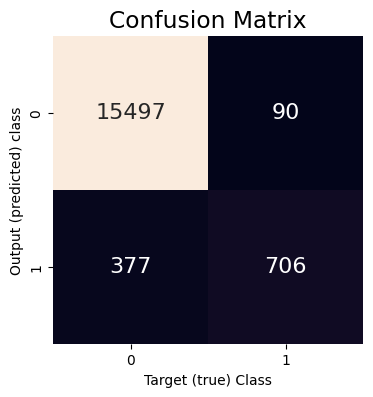

              precision    recall  f1-score   support

       licit     0.9763    0.9942    0.9852     15587
     illicit     0.8869    0.6519    0.7515      1083

    accuracy                         0.9720     16670
   macro avg     0.9316    0.8231    0.8683     16670
weighted avg     0.9704    0.9720    0.9700     16670



In [13]:
model = TGNN(input_dim, output_dim, K1, K2).to(device)

model.load_state_dict(torch.load(os.path.join(checkpoints_dir, 'tgnn_model.pth.tar'))['state_dict'])

y_test_preds = test(model, data_train)

# confusion matrix on validation data
conf_mat = confusion_matrix(data_train.y[data_train.val_idx].detach().cpu().numpy(), y_test_preds[valid_idx].cpu())

plt.subplots(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False)
plt.xlabel('Target (true) Class'); plt.ylabel('Output (predicted) class'); plt.title('Confusion Matrix')
plt.show()

print(classification_report(data_train.y[data_train.val_idx].detach().cpu().numpy(),
                            y_test_preds[valid_idx].cpu(),
                            target_names=['licit', 'illicit'], digits=4))

Для сравнения приложим метрики других моделей, которые были вычислены в статье [1], к которой прилагался датасет
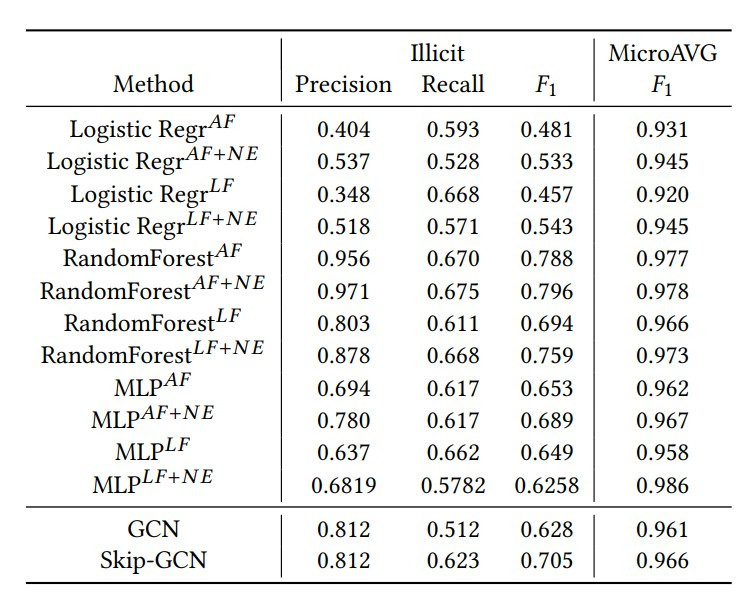 

Таким образом, наш метод уступает, в сущности, только случайному лесу

[[1]: https://arxiv.org/pdf/1908.02591.pdf](https://arxiv.org/pdf/1908.02591.pdf)